In [2]:
import sys
sys.path.append('../')

import os 
import math
import cv2

from typing import Mapping, Any, List, Tuple, Optional, Callable
from collections import OrderedDict
from os.path import join as pjoin
from scipy.special import expit
from PIL import Image

import h5py

from os.path import join as pjoin
from glob import glob

from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision.transforms as T
import albumentations as albu
import timm

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
cv2.resize(np.random.randn(11, 512,512), (256,256)).shape

In [ ]:
mask = np.load('/data/tube_masks_channel_640_640/1.2.826.0.1.3680043.8.498.10012076044416201719708790381665812951.npy')

In [ ]:
plt.imshow(mask[:,:,9])

# Data

In [3]:
PATH2DIR = '/data/'
os.listdir(PATH2DIR)

train_df = pd.read_csv(pjoin(PATH2DIR, 'train.csv'))
train_df

StudyInstanceUID  ETT - Abnormal  \
0      1.2.826.0.1.3680043.8.498.26697628953273228189...               0   
1      1.2.826.0.1.3680043.8.498.46302891597398758759...               0   
2      1.2.826.0.1.3680043.8.498.23819260719748494858...               0   
3      1.2.826.0.1.3680043.8.498.68286643202323212801...               0   
4      1.2.826.0.1.3680043.8.498.10050203009225938259...               0   
...                                                  ...             ...   
30078  1.2.826.0.1.3680043.8.498.74257566841157531124...               0   
30079  1.2.826.0.1.3680043.8.498.46510939987173529969...               0   
30080  1.2.826.0.1.3680043.8.498.43173270582850645437...               0   
30081  1.2.826.0.1.3680043.8.498.95092491950130838685...               0   
30082  1.2.826.0.1.3680043.8.498.99518162226171269731...               0   

       ETT - Borderline  ETT - Normal  NGT - Abnormal  NGT - Borderline  \
0                     0             0               0                 0   
1                     0             1               0                 0   
2                     0             0               0                 0   
3                     0             0               0                 0   
4                     0             0               0                 0   
...                 ...           ...             ...               ...   
30078                 0             1               0                 0   
30079                 0             0               0                 0   
30080                 0             1               0                 0   
30081                 0             0               0                 0   
30082                 0             1               0                 0   

       NGT - Incompletely Imaged  NGT - Normal  CVC - Abnormal  \
0                              0             1               0   
1                              1             0               0   
2                              0             0               0   
3                              0             0               1   
4                              0             0               0   
...                          ...           ...             ...   
30078                          0             0               0   
30079                          0             0               0   
30080                          1             0               1   
30081                          0             0               0   
30082                          0             0               0   

       CVC - Borderline  CVC - Normal  Swan Ganz Catheter Present  PatientID  
0                     0             0                           0  ec89415d1  
1                     0             1                           0  bf4c6da3c  
2                     1             0                           0  3fc1c97e5  
3                     0             0                           0  c31019814  
4                     0             1                           0  207685cd1  
...                 ...           ...                         ...        ...  
30078                 1             1                           0  5b5b9ac30  
30079                 0             1                           0  7192404d8  
30080                 0             1                           0  d4d1b066d  
30081                 1             0                           0  01a6602b8  
30082                 0             1                           0  e692d316c  

[30083 rows x 13 columns]

# Check augs

In [4]:
def load_image(
    filename: str,
    use_pil: bool = False
):
    if use_pil:
        return Image.open(pjoin(
            PATH2DIR, 
            'train_640_640',
            filename + '.jpeg'
        ))
    else:
        temp_im = cv2.imread(pjoin(
            PATH2DIR, 
            'train_640_640',
            filename + '.jpeg'
        ))
        return cv2.cvtColor(temp_im, cv2.COLOR_BGR2RGB)

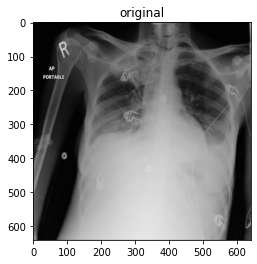

In [5]:
idx = np.random.randint(low=0, high=len(train_df))

or_im = load_image(train_df.iloc[idx].StudyInstanceUID)

plt.title('original')
plt.imshow(or_im)
plt.show()

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
trans = ToTensorV2()

In [ ]:
def show_trans(input):
    plt.imshow(input.permute(1,2,0))
    plt.show()

In [ ]:
show_trans(trans(image=or_im)['image'].transpose(-1,-2).flip(-1))

In [ ]:
or_im.shape

In [ ]:
timm_autoaugment = timm.data.auto_augment_transform('originalr', None)

In [ ]:
idx = np.random.randint(low=0, high=len(train_df))

or_im = load_image(train_df.iloc[idx].image_id, use_pil=True)

plt.title('original')
plt.imshow(timm_autoaugment(or_im))
plt.show()

In [ ]:
plt.imshow(np.array(timm_autoaugment(or_im)))

In [ ]:
h_f_aug =  albu.Compose(
                [
#                     albu.Transpose(p=0.5),
#                     albu.HorizontalFlip(p=0.5),
#                     albu.VerticalFlip(p=0.5),
#                     albu.ShiftScaleRotate(p=0.5),
#                     albu.HueSaturationValue(
#                                 hue_shift_limit=0.2, 
#                                 sat_shift_limit=0.2, 
#                                 val_shift_limit=0.2, 
#                                 p=0.5),
#                     albu.RandomBrightnessContrast(
#                                     brightness_limit=(-0.1,0.1), 
#                                     contrast_limit=(-0.1, 0.1), 
#                                     p=0.5),
#                     albu.RGBShift(),
#                     albu.ChannelDropout(),
                    albu.Cutout(p=1.0, max_h_size=64, max_w_size=64),
    ])

plt.title('Horizontal flip')
plt.imshow(h_f_aug(image=or_im)['image'])
plt.show()

In [6]:
v_f_aug = albu.VerticalFlip(p=1.0)

h_f_aug = albu.HorizontalFlip(p=1.0)

v_h_f_aug = albu.Compose([
    albu.VerticalFlip(p=1.0),
    albu.HorizontalFlip(p=1.0)
])

h_v_f_aug = albu.Compose([
    albu.HorizontalFlip(p=1.0),
    albu.VerticalFlip(p=1.0)
])

rot90_aug = albu.RandomRotate90(p=1.0)

transp_aug_vf = albu.Compose([albu.Transpose(p=1.0), albu.VerticalFlip(p=1.0)])

transp_aug_hf = albu.Compose([albu.Transpose(p=1.0), albu.HorizontalFlip(p=1.0)])

transp_aug_vf_inv = albu.Compose([albu.VerticalFlip(p=1.0), albu.Transpose(p=1.0)])

transp_aug_hf_inv = albu.Compose([albu.HorizontalFlip(p=1.0), albu.Transpose(p=1.0)])

transp_aug = albu.Transpose(p=1.0)

small_rot_left = albu.ShiftScaleRotate(
    shift_limit=0,
    scale_limit=0,
    rotate_limit=(15,16),
    p=1.0
)

small_rot_right = albu.ShiftScaleRotate(
    shift_limit=0,
    scale_limit=0,
    rotate_limit=(-16,-15),
    p=1.0
)

In [ ]:
plt.imshow(small_rot_right(image=or_im)['image'])

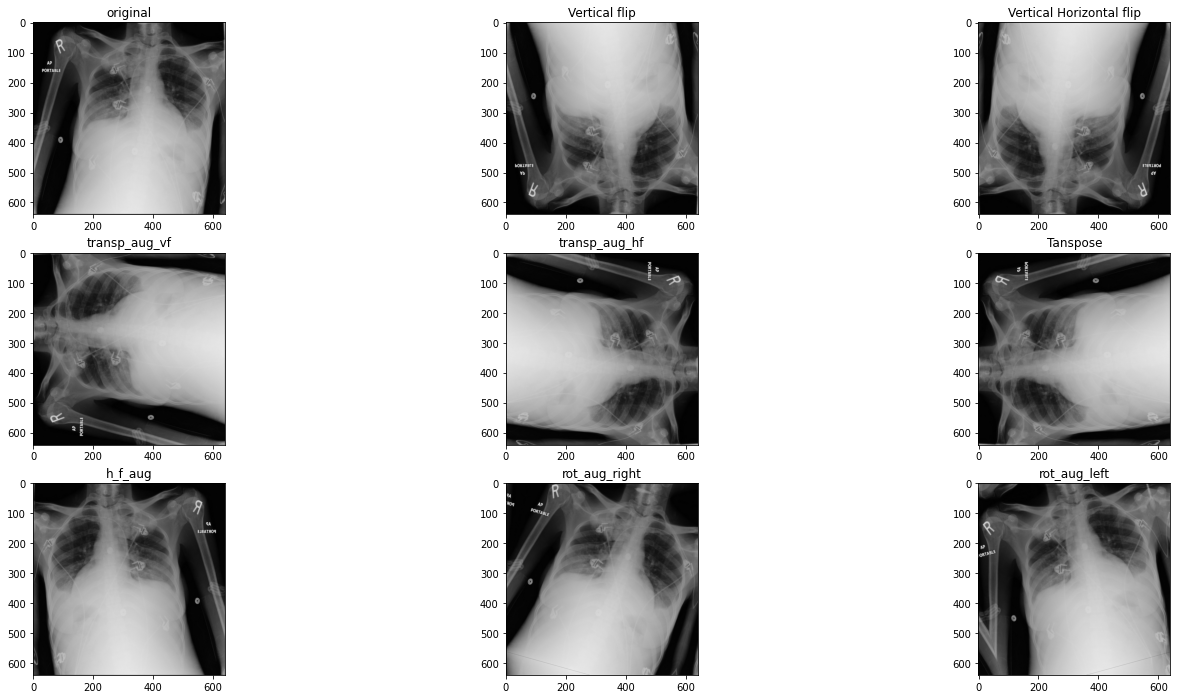

In [7]:
plt.figure(figsize=(24, 12))

ax = plt.subplot(3, 3, 1)
ax.set_title('original')
ax.imshow(or_im)

ax = plt.subplot(3, 3, 2)
ax.set_title('Vertical flip')
ax.imshow(v_f_aug(image=or_im)['image'])

ax = plt.subplot(3, 3, 3)
ax.set_title('Vertical Horizontal flip')
ax.imshow(v_h_f_aug(image=or_im)['image'])

# ax = plt.subplot(3, 3, 4)
# ax.set_title('Horizontal Vertical flip')
# ax.imshow(h_v_f_aug(image=or_im)['image'])

# ax = plt.subplot(3, 3, 5)
# ax.set_title('Rotate 90')
# ax.imshow(rot90_aug(image=or_im)['image'])

ax = plt.subplot(3, 3, 4)
ax.set_title('transp_aug_vf')
ax.imshow(transp_aug_vf(image=or_im)['image'])

ax = plt.subplot(3, 3, 5)
ax.set_title('transp_aug_hf')
ax.imshow(transp_aug_hf(image=or_im)['image'])

ax = plt.subplot(3, 3, 6)
ax.set_title('Tanspose')
ax.imshow(transp_aug(image=or_im)['image'])

ax = plt.subplot(3, 3, 7)
ax.set_title('h_f_aug')
ax.imshow(h_f_aug(image=or_im)['image'])

ax = plt.subplot(3, 3, 8)
ax.set_title('rot_aug_right')
ax.imshow(small_rot_right(image=or_im)['image'])

ax = plt.subplot(3, 3, 9)
ax.set_title('rot_aug_left')
ax.imshow(small_rot_left(image=or_im)['image'])

# ax = plt.subplot(3, 3, 7)
# ax.set_title('transp_aug_vf_inv')
# ax.imshow(transp_aug_vf_inv(image=or_im)['image'])

# ax = plt.subplot(3, 3, 8)
# ax.set_title('transp_aug_hf_inv')
# ax.imshow(transp_aug_hf_inv(image=or_im)['image'])

plt.show()

In [ ]:
plt.figure(figsize=(24, 12))

ax = plt.subplot(3, 3, 1)
ax.set_title('original')
ax.imshow(or_im)

ax = plt.subplot(3, 3, 2)
ax.set_title('Vertical flip')
ax.imshow(v_f_aug(image=or_im)['image'])

ax = plt.subplot(3, 3, 3)
ax.set_title('Vertical Horizontal flip')
ax.imshow(v_h_f_aug(image=or_im)['image'])

# ax = plt.subplot(3, 3, 4)
# ax.set_title('Horizontal Vertical flip')
# ax.imshow(h_v_f_aug(image=or_im)['image'])

# ax = plt.subplot(3, 3, 5)
# ax.set_title('Rotate 90')
# ax.imshow(rot90_aug(image=or_im)['image'])

ax = plt.subplot(3, 3, 4)
ax.set_title('transp_aug_vf')
ax.imshow(transp_aug_vf(image=or_im)['image'])

ax = plt.subplot(3, 3, 5)
ax.set_title('transp_aug_hf')
ax.imshow(transp_aug_hf(image=or_im)['image'])

ax = plt.subplot(3, 3, 6)
ax.set_title('Tanspose')
ax.imshow(transp_aug(image=or_im)['image'])

plt.show()

In [ ]:
v_f_aug = albu.VerticalFlip(p=1.0)

In [ ]:
v_h_f_aug = albu.Compose([
    albu.VerticalFlip(p=1.0),
    albu.HorizontalFlip(p=1.0)
])

In [ ]:
h_v_f_aug = albu.Compose([
    albu.HorizontalFlip(p=1.0),
    albu.VerticalFlip(p=1.0)
])

In [ ]:
rot90_aug = albu.RandomRotate90(p=1.0)

In [ ]:
transp_aug_vf = albu.Compose([albu.Transpose(p=1.0), albu.VerticalFlip(p=1.0)])

In [ ]:
transp_aug_hf = albu.Compose([albu.Transpose(p=1.0), albu.HorizontalFlip(p=1.0)])

In [ ]:
transp_aug = albu.Transpose(p=1.0)

plt.title('Tanspose')
plt.imshow(transp_aug(image=or_im)['image'])
plt.show()

In [ ]:
hf_rot90_aug = albu.Compose([
    albu.HorizontalFlip(p=1.0),
    albu.RandomRotate90(p=1.0)
])

plt.title('Horizontal flip Rotate 90')
plt.imshow(hf_rot90_aug(image=or_im)['image'])
plt.show()

In [ ]:
cutout_aug = albu.Cutout(
    max_h_size=16,
    max_w_size=16,
    p=1.0
)

plt.title('Cutout')
plt.imshow(cutout_aug(image=or_im)['image'])
plt.show()

In [ ]:
shiftscalerot_aug = albu.ShiftScaleRotate(rotate_limit=20, shift_limit=0.2, border_mode=3, p=1.0,)

plt.title('ShiftScaleRotate')
plt.imshow(shiftscalerot_aug(image=or_im)['image'])
plt.show()

In [ ]:
blur_aug = albu.Blur(blur_limit=3, p=1.0)

plt.title('Blur')
plt.imshow(blur_aug(image=or_im)['image'])
plt.show()

In [ ]:
rgbshift_aug = albu.RGBShift(p=1.0)

plt.title('RGBShift')
plt.imshow(rgbshift_aug(image=or_im)['image'])
plt.show()